In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from unet import UNet, FullUNet, MediumUNet, OneLayerUNet, ExtraDeepUNet, SuperDeepUNet
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from tqdm.notebook import tqdm
import sigpy as sp
import sigpy.mri as mr
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
# from models import skip
#from DIP_UNET_models.skip import skip
import glob
import two_channel_dataset_DIP
from torch.nn import init

file1000591.h5_Layer16.npz
[843]


In [2]:
for test_direct,test_target,test_smap,test_mask,test_mask_in,no_crop_smap,test_kspace in two_channel_dataset_DIP.test_loader:
    k_np =test_kspace
    A_k_ref = k_np[:,:, 0, :, :] + 1j * k_np[:,:, 1, :, :]
    sense_maps_ref = no_crop_smap[:,:, 0, :, :] + 1j *no_crop_smap[:,:, 1, :, :]

torch.Size([1, 15, 640, 372])
torch.Size([640, 372])


In [3]:
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


In [4]:
def fft_with_shifts(img):
    return fft.fftshift(fft.fft2(fft.ifftshift(img)))

def ifft_with_shifts(ksp):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ksp)))

def ksp_and_mps_to_gt(ksp, mps):
    gt = mps.conj() * ifft_with_shifts(ksp)
    gt = torch.sum(gt, axis=0)
    return gt

def mps_and_gt_to_ksp(mps, gt):
    ksp = fft_with_shifts(mps * gt)
    return ksp

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
net = MediumUNet(n_channels=2, n_classes=2).to(device)
init_weights(net, init_type='normal',init_gain=0.02)
num_epochs = 500
learning_rate = 3e-4
show_every = 50

initialize network with normal


In [7]:
sum([p.numel() for p in net.parameters()])

14906050

In [8]:
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [9]:
criterion = nn.L1Loss()

In [10]:
#new_ref = ksp_and_mps_to_gt(A_k_neighbor[0], sense_map_neighbor[0])

In [11]:
ksp1 = A_k_ref[0]

In [12]:
mps1 = sense_maps_ref[0]

In [13]:
new_ref = ksp_and_mps_to_gt(mask_from_file * ksp1, mps1)

In [14]:
print(torch.max(torch.abs(new_ref)))

tensor(9.9664e-05)


In [17]:
ref = torch.zeros(1,2,640,372)
ref[:,0,:,:] = new_ref.real
ref[:,1,:,:] = new_ref.imag

In [18]:
ref = ref/torch.max(torch.abs(ref))

In [19]:
with torch.no_grad():
    scale_factor = torch.linalg.norm(net(ref.to(device)))/torch.linalg.norm(ksp_and_mps_to_gt(ksp1, mps1).to(device))
    target_ksp = scale_factor * ksp1.to(device)
    print('K-space scaled by: ', scale_factor)

K-space scaled by:  tensor(8537.3926, device='cuda:0')


In [20]:
gt1 = ksp_and_mps_to_gt(ksp1, mps1)

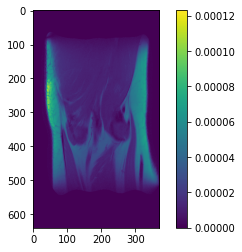

In [21]:
plt.imshow(torch.abs(gt1).numpy())
plt.colorbar()

In [22]:
img_map = torch.sum(torch.abs(mps1), axis=0) > 0
img_map = img_map#.type(dtype)

In [23]:
losses = []
psnrs = []
avg_psnrs = []
exp_weight = .99
out_avg = torch.zeros_like(torch.abs(gt1)).to(device)

  0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_168420/3316106610.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_pred_ksp = (1 - torch.tensor(mask_from_file,dtype=torch.complex64)).to(device) * pred_ksp.detach()/scale_factor \


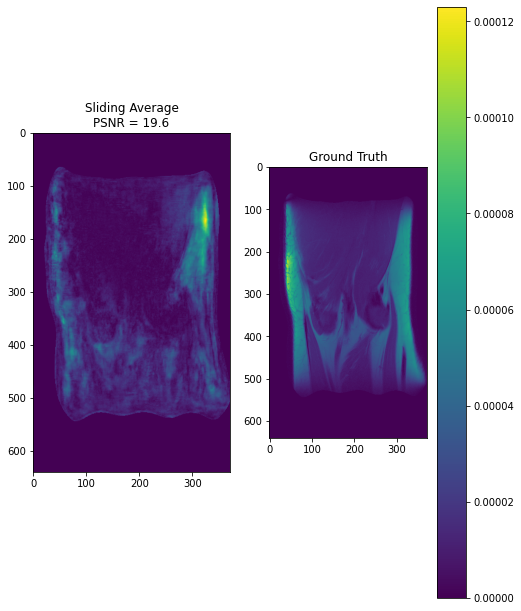

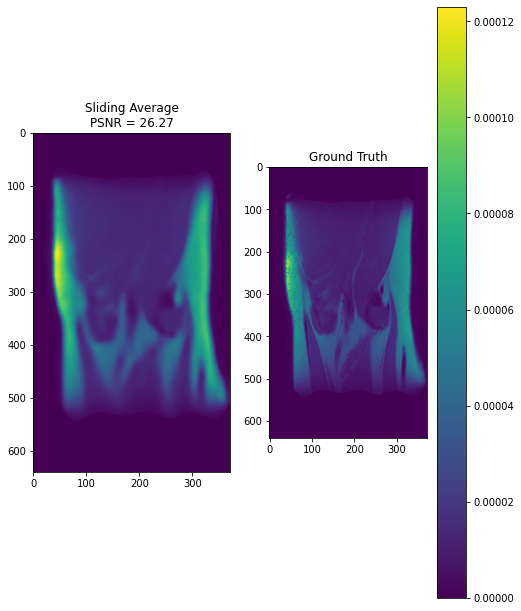

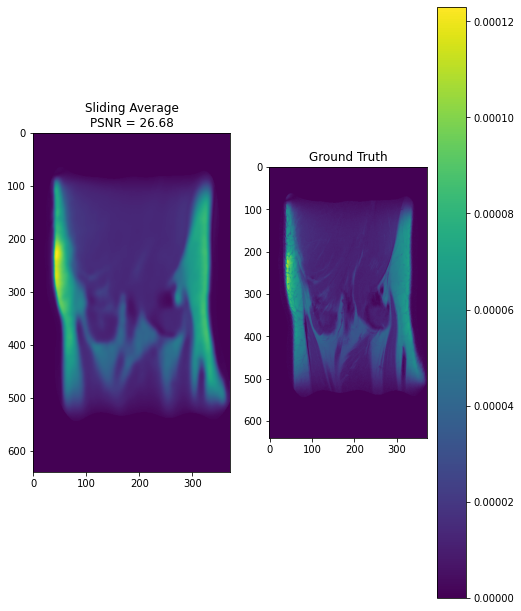

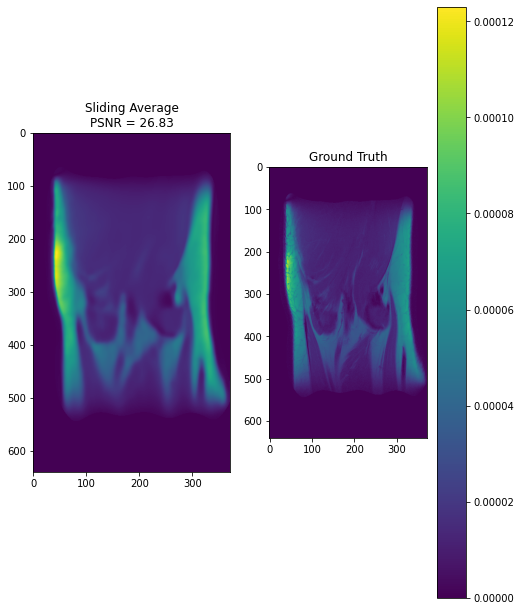

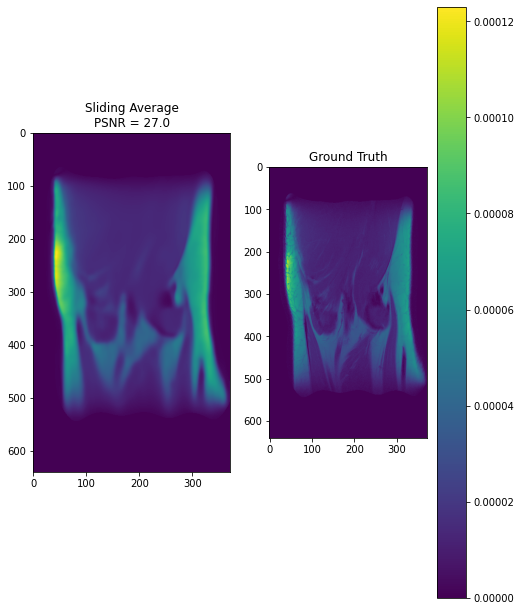

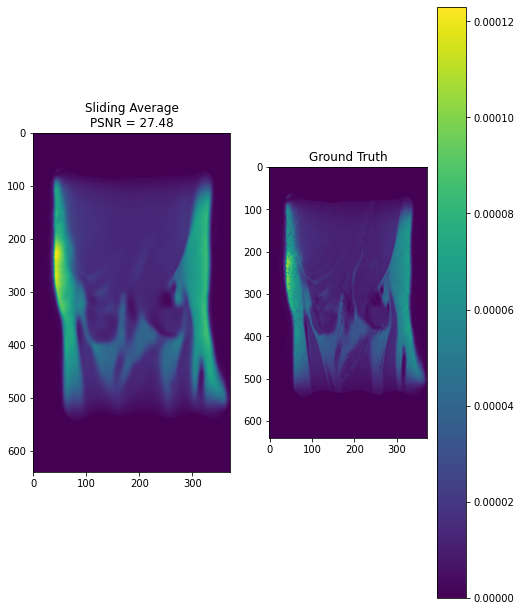

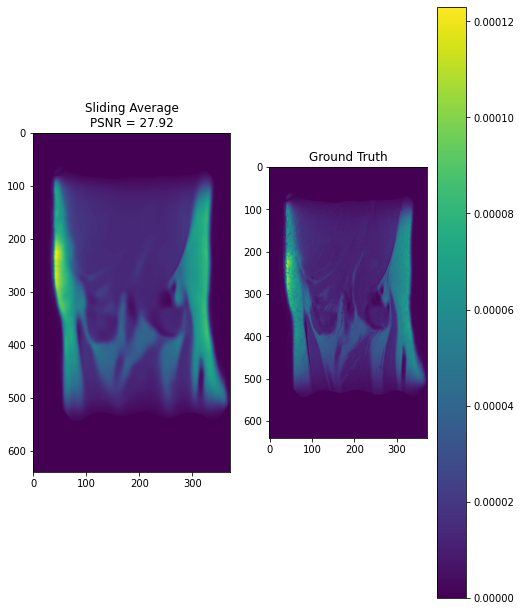

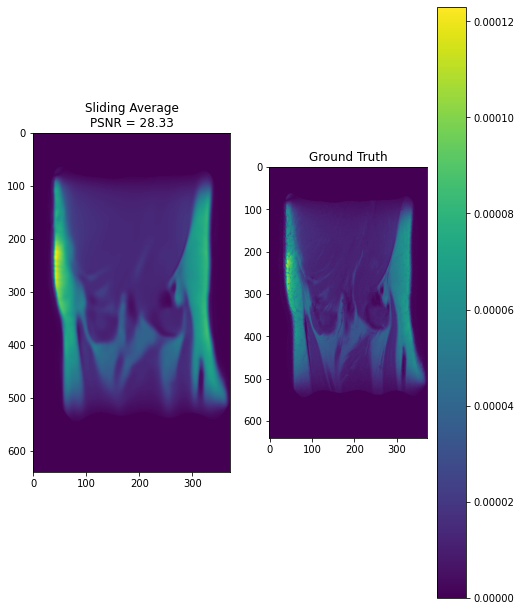

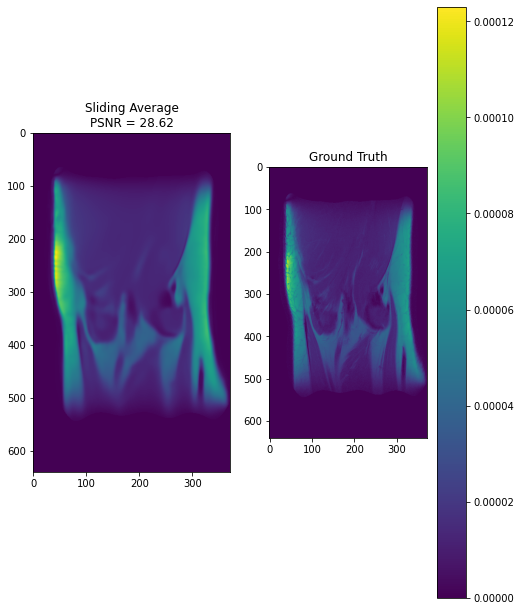

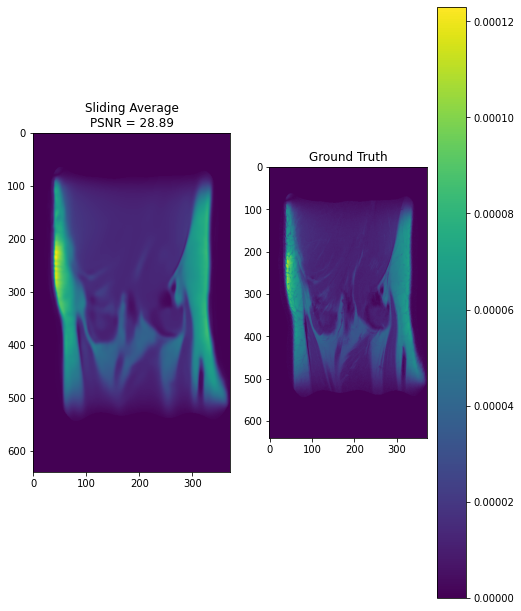

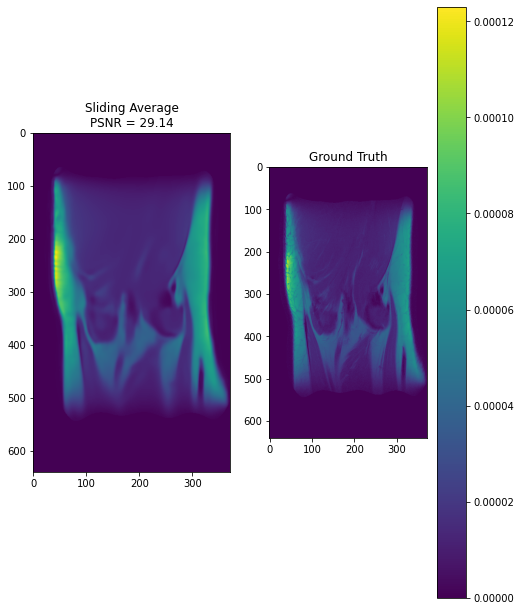

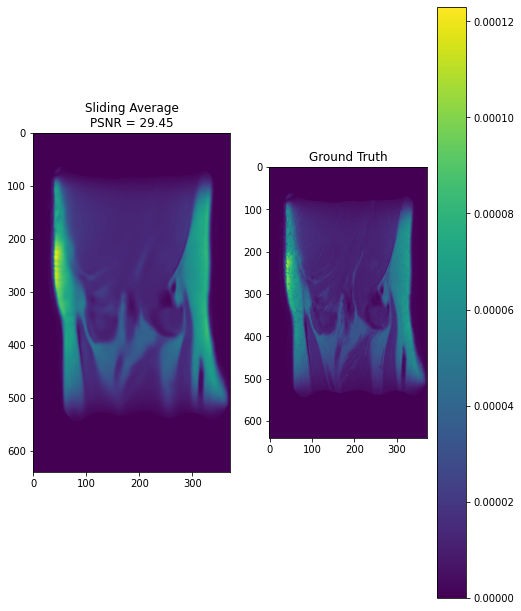

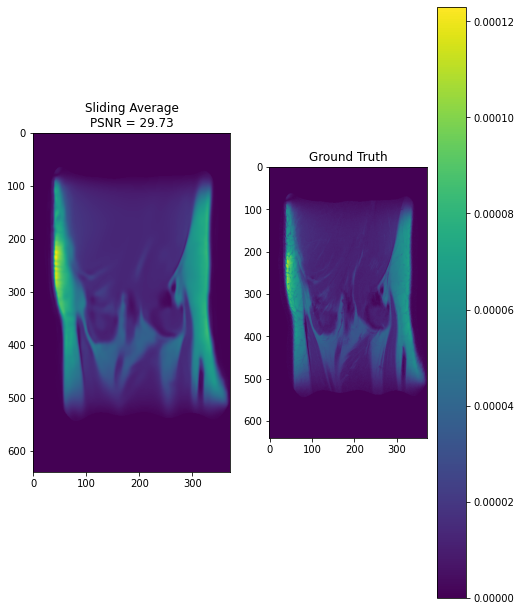

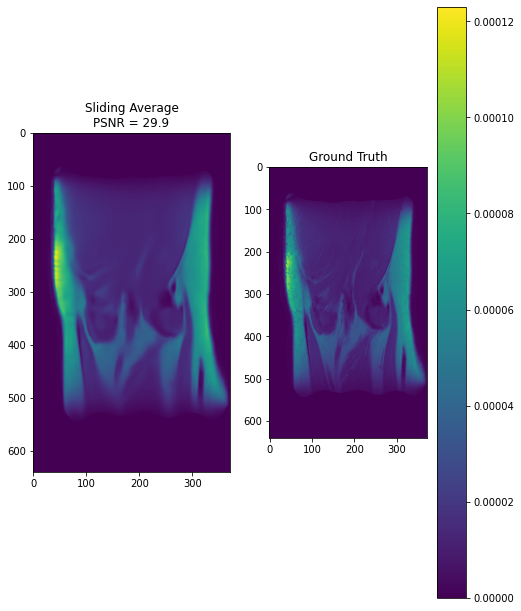

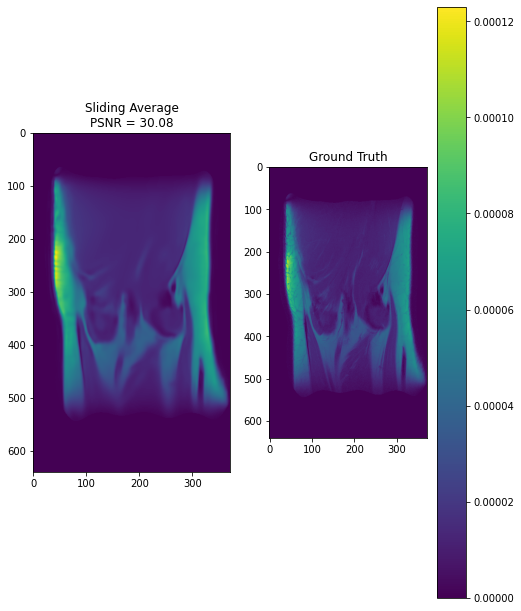

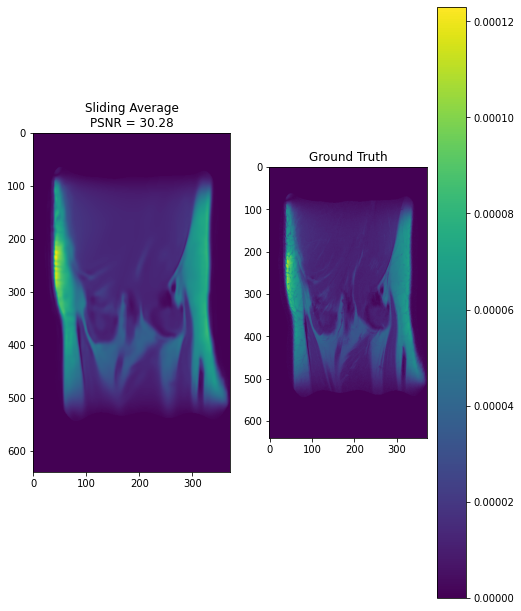

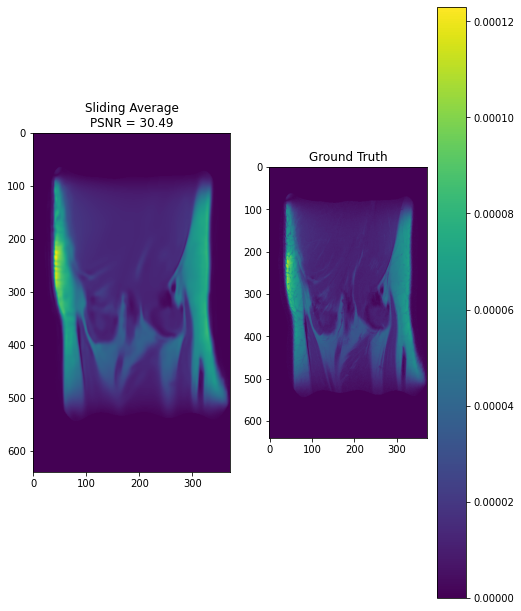

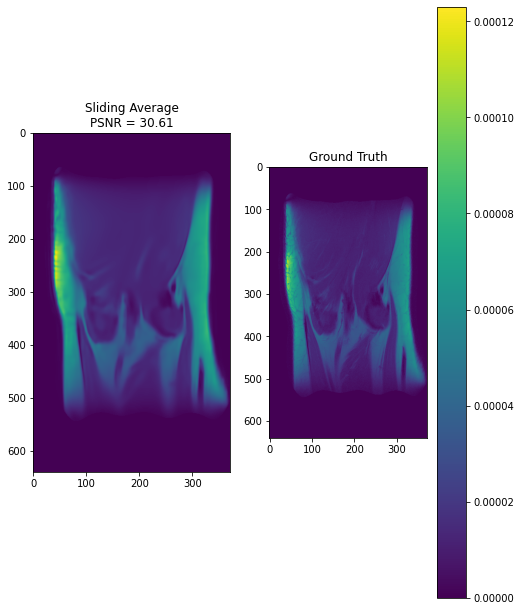

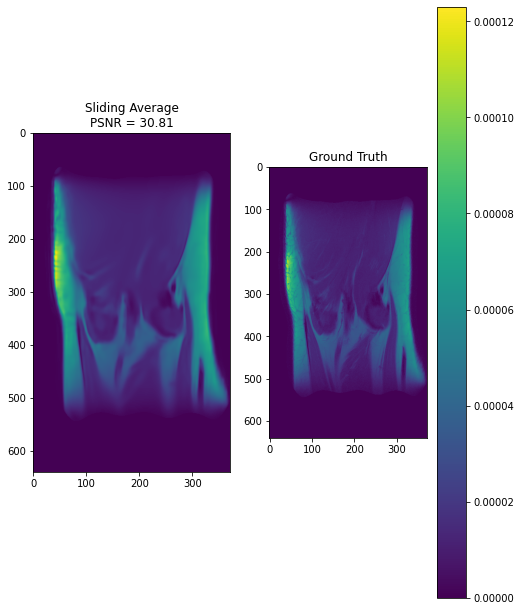

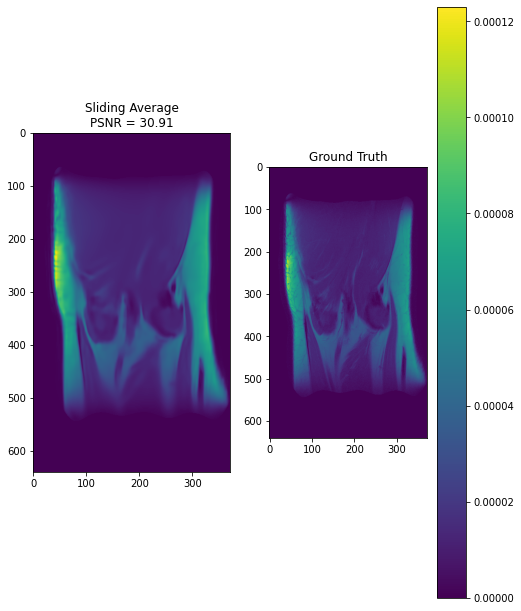

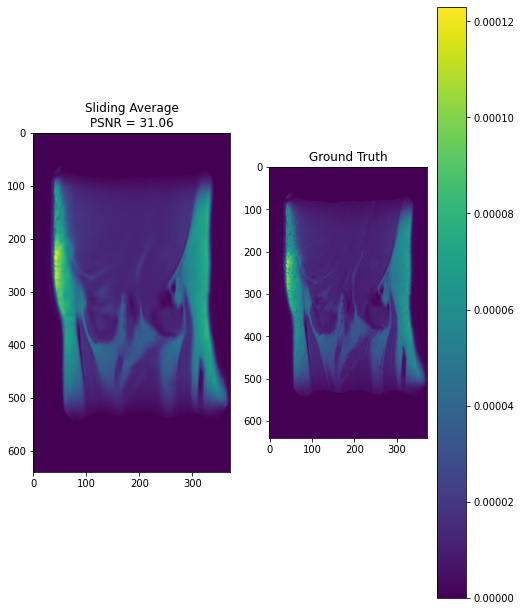

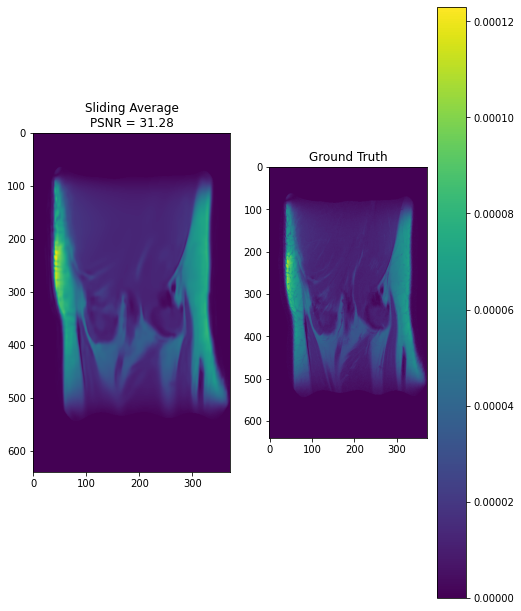

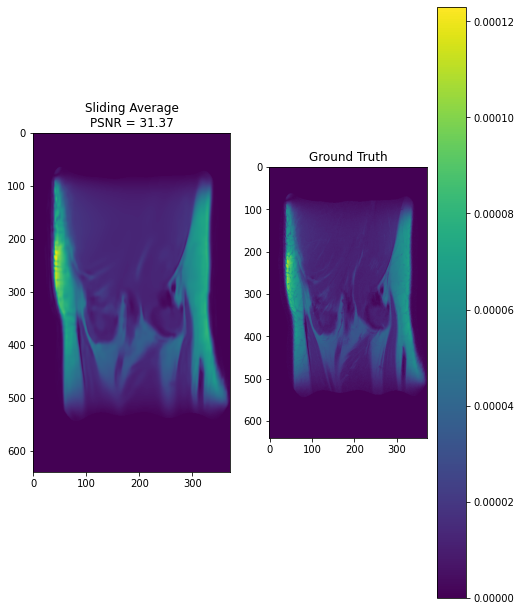

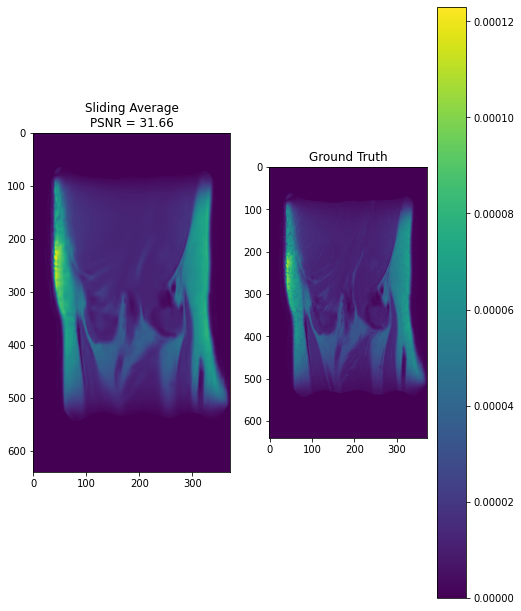

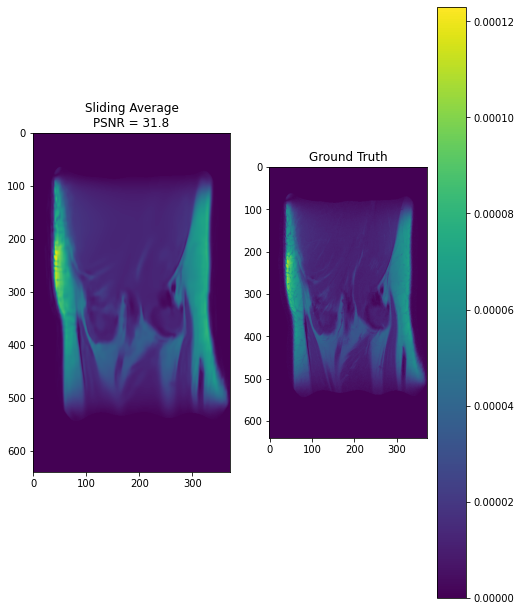

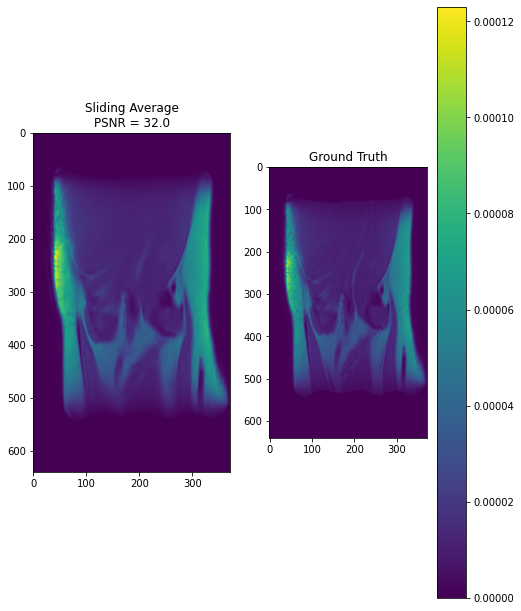

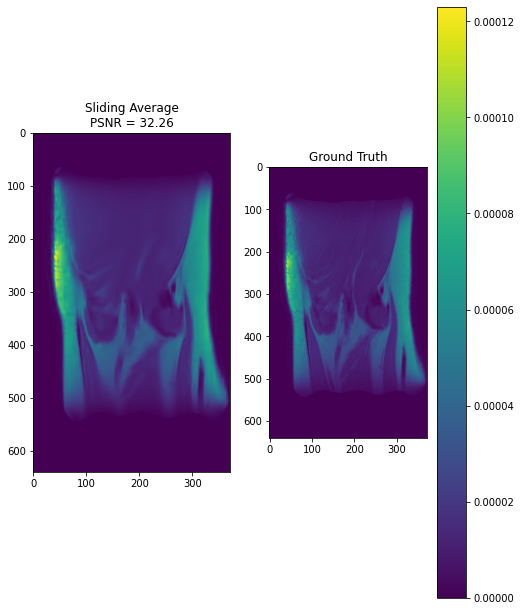

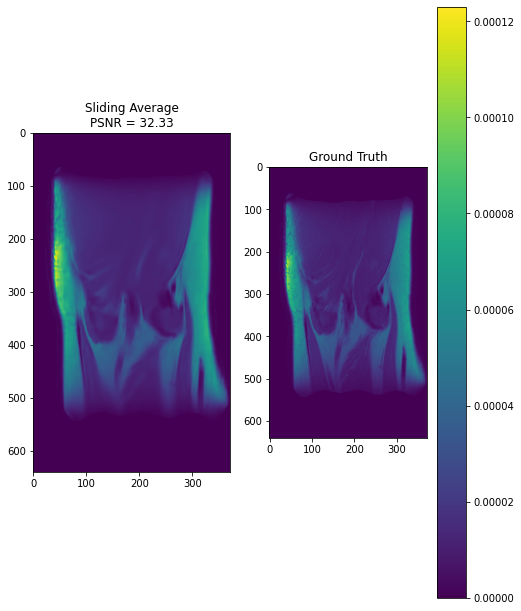

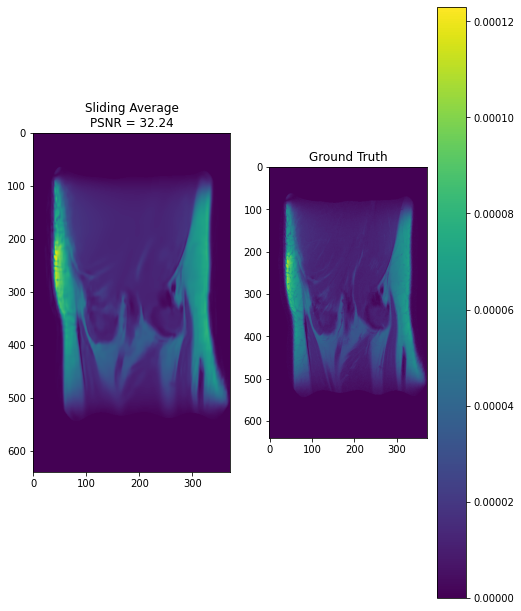

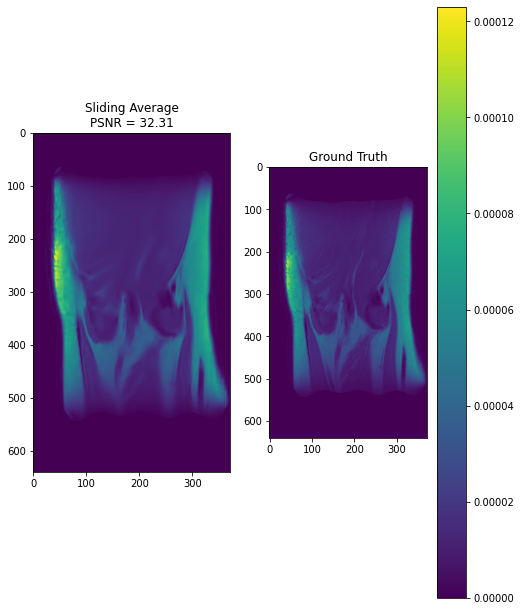

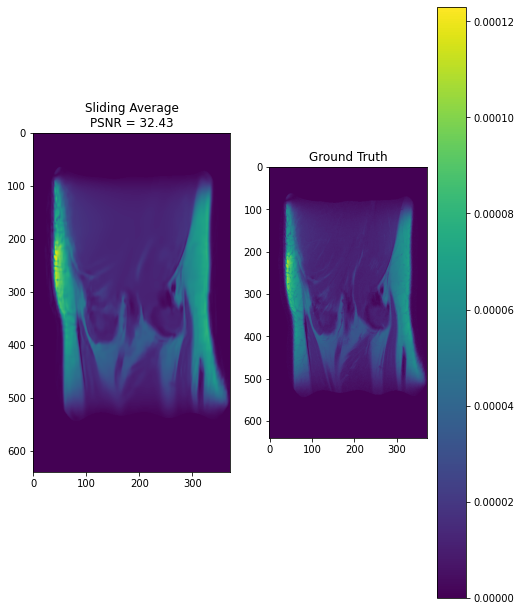

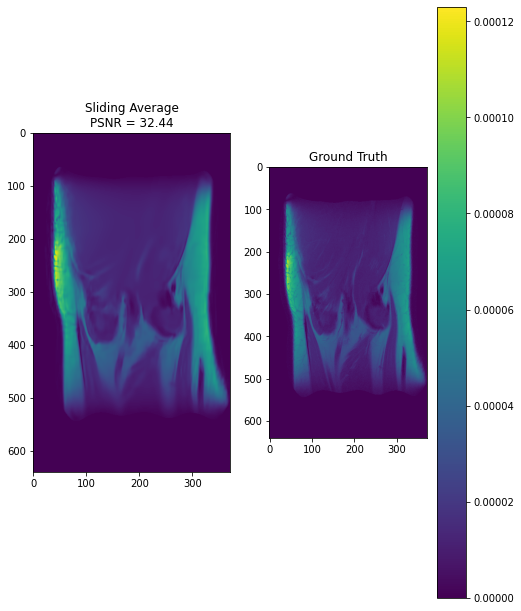

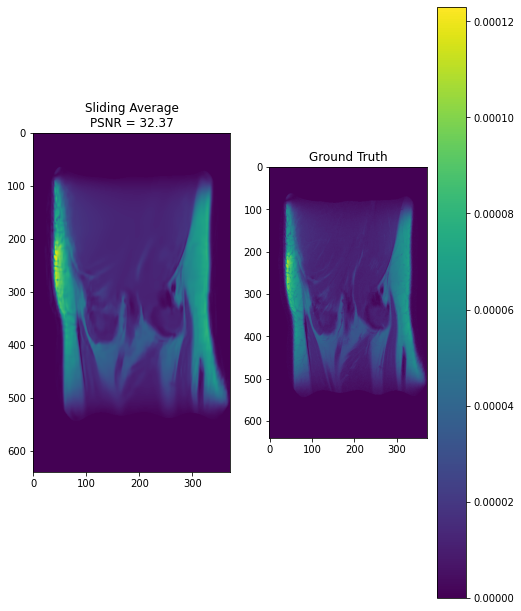

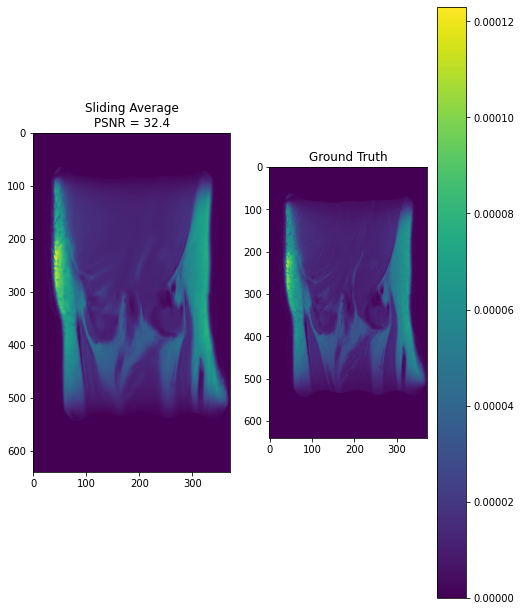

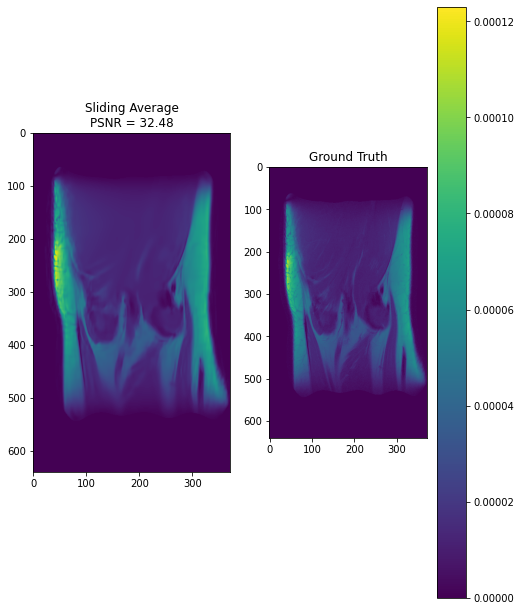

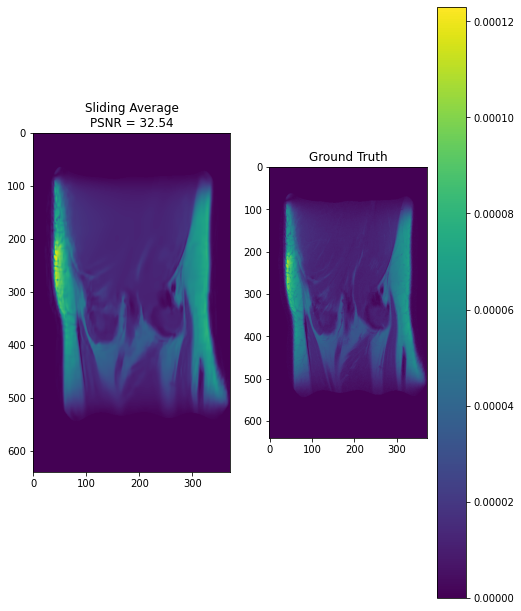

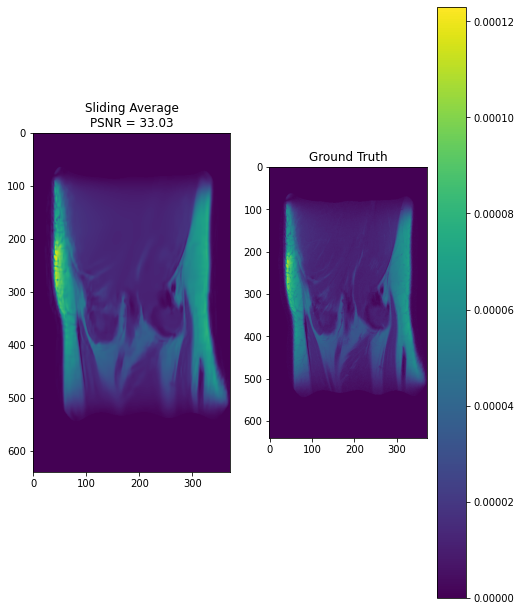

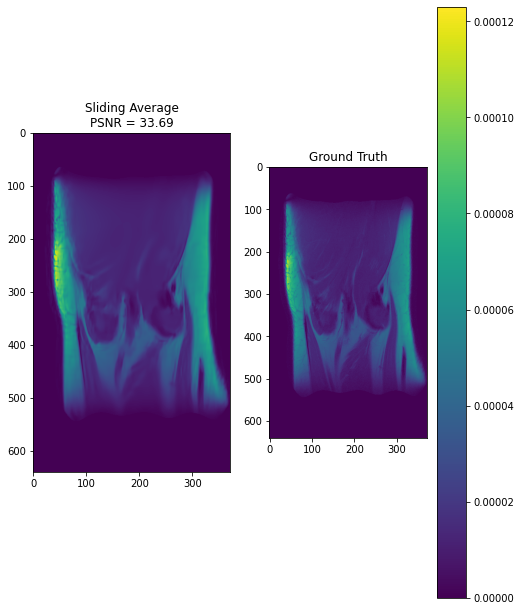

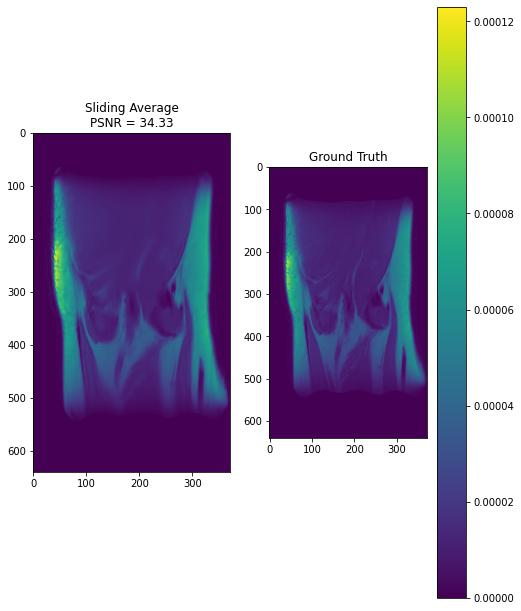

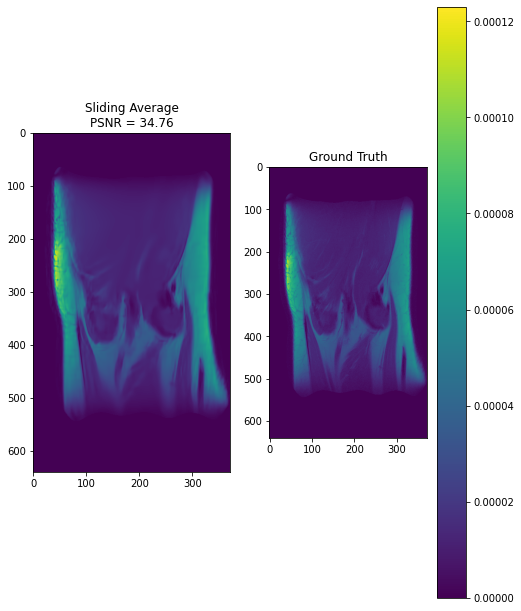

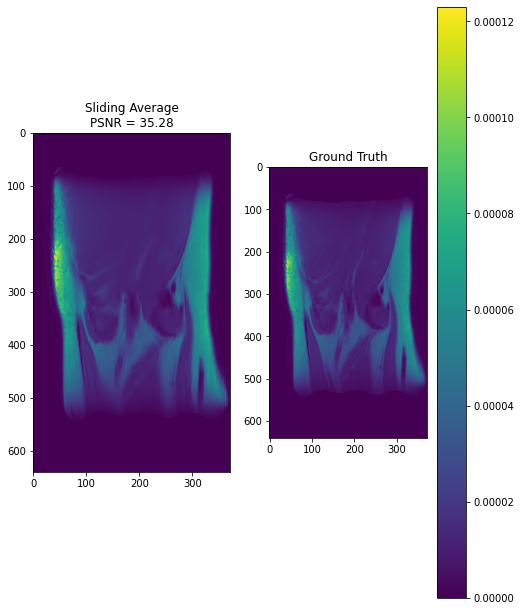

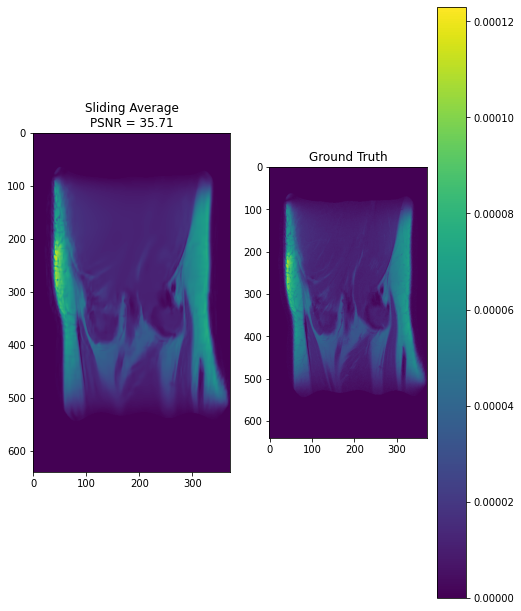

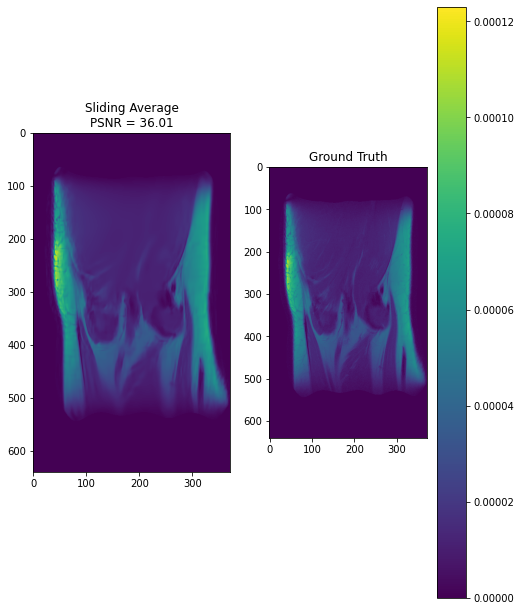

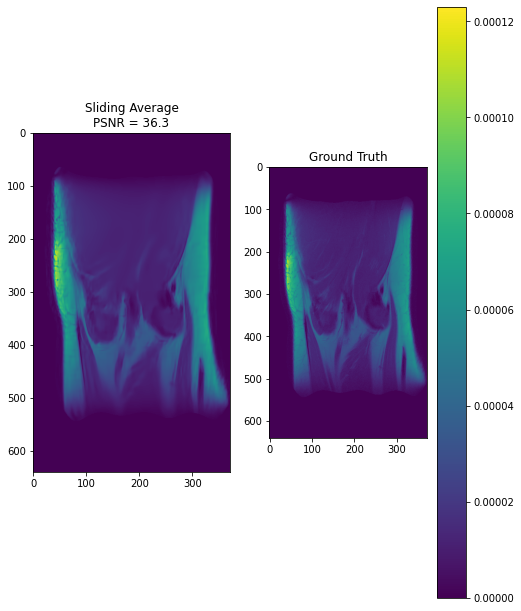

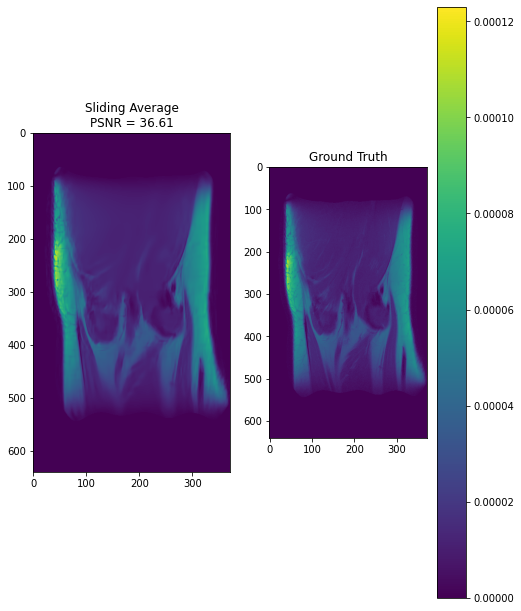

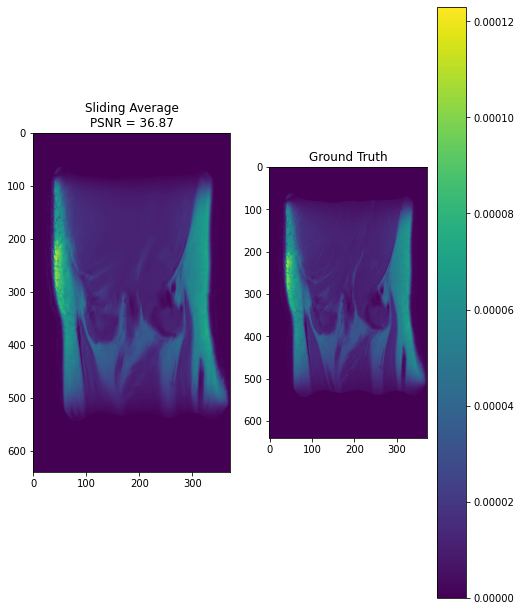

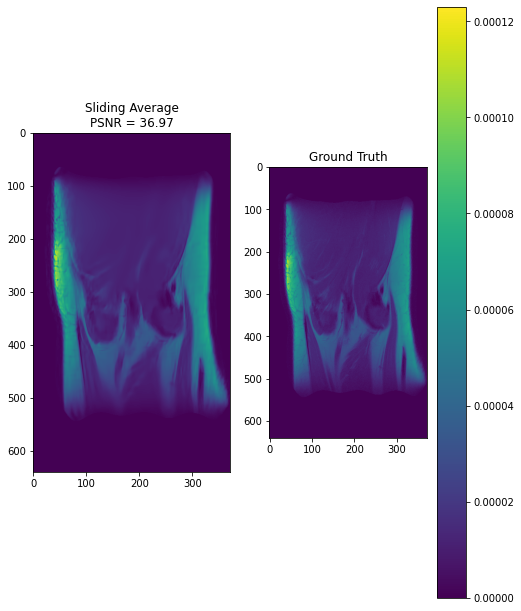

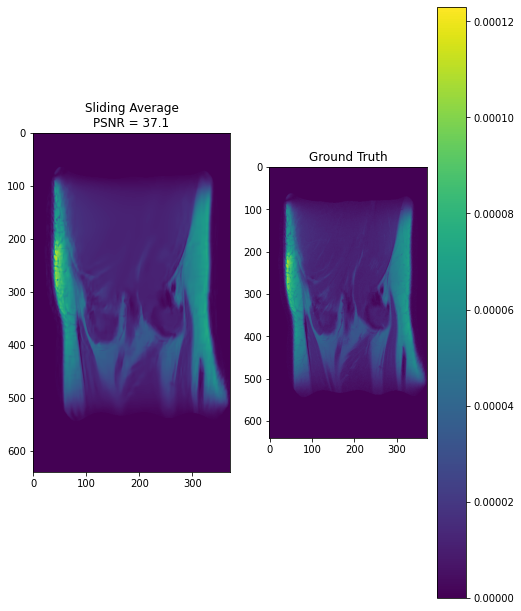

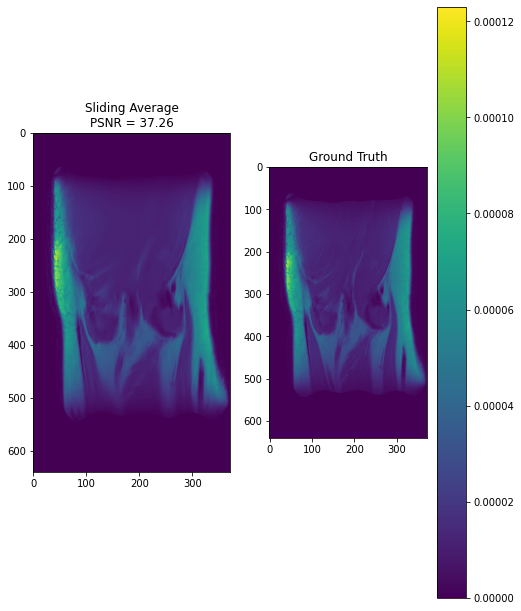

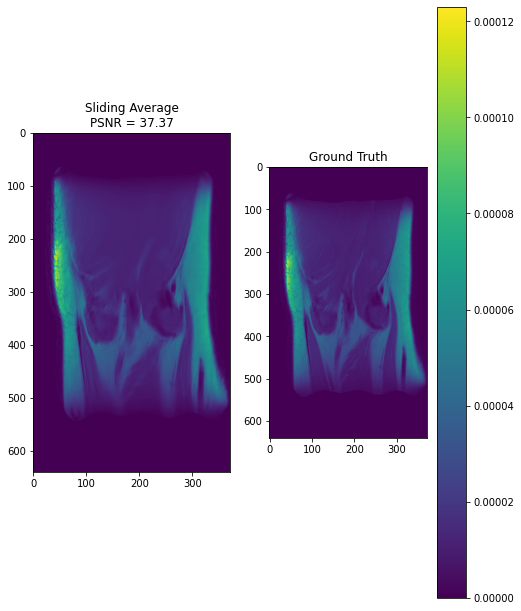

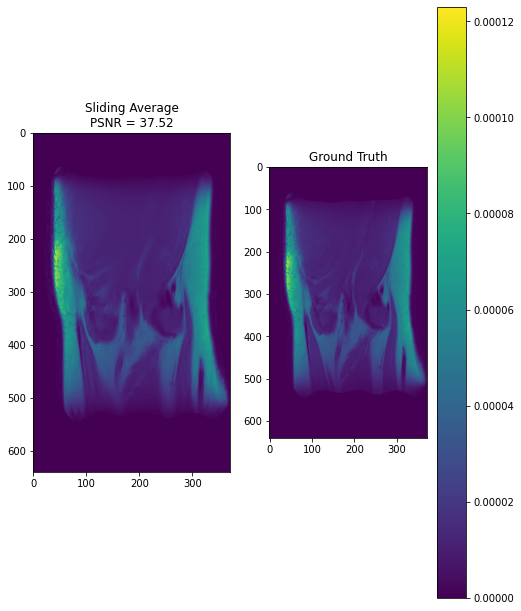

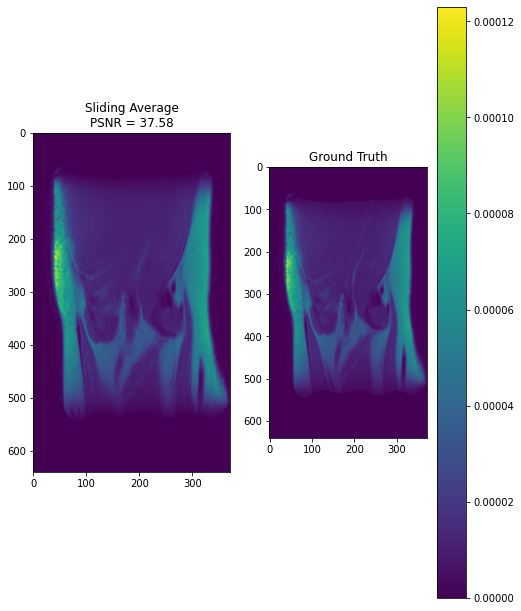

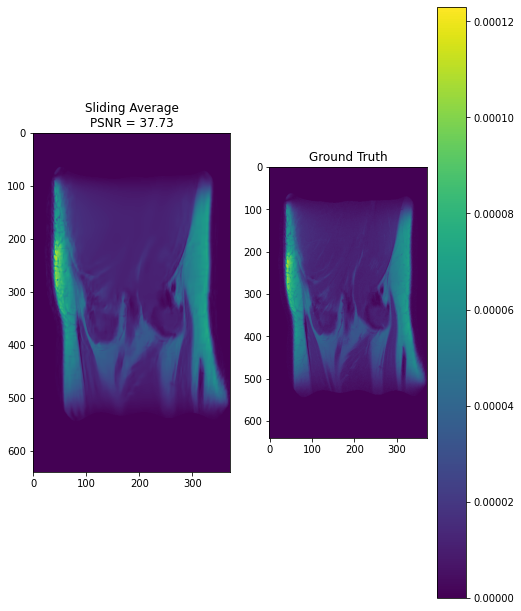

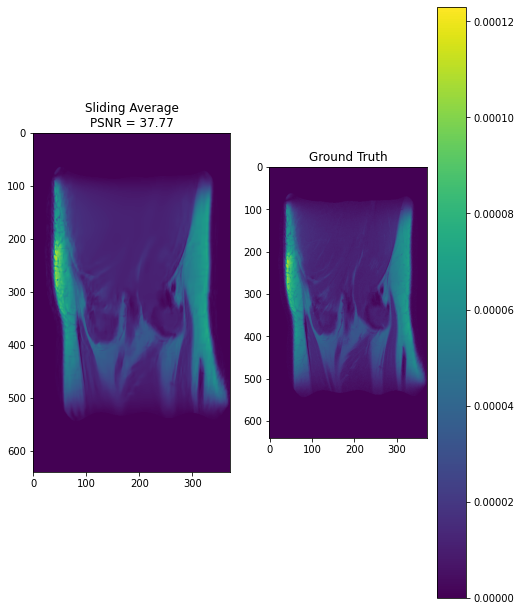

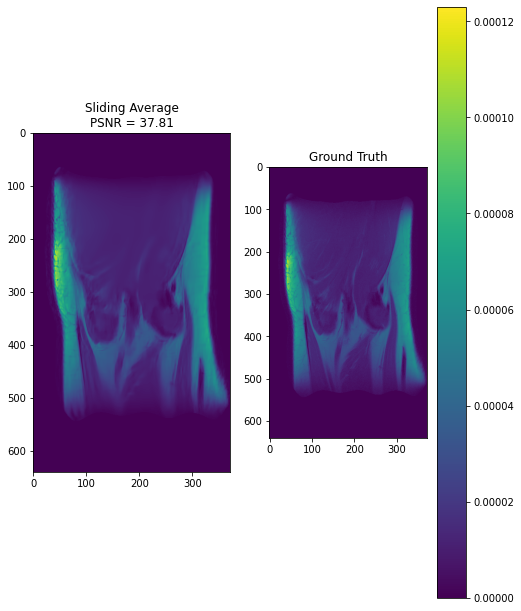

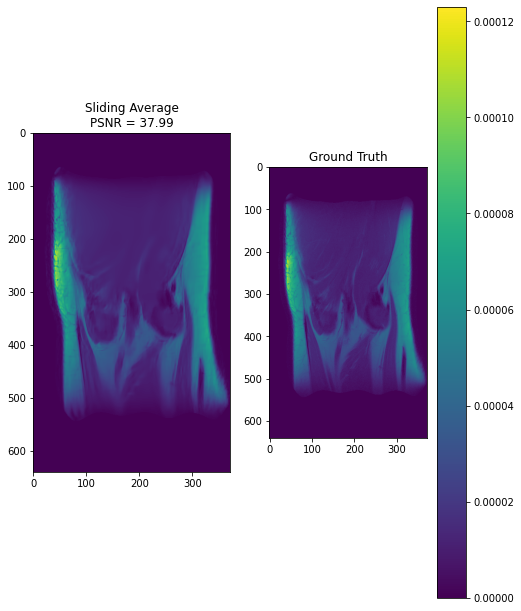

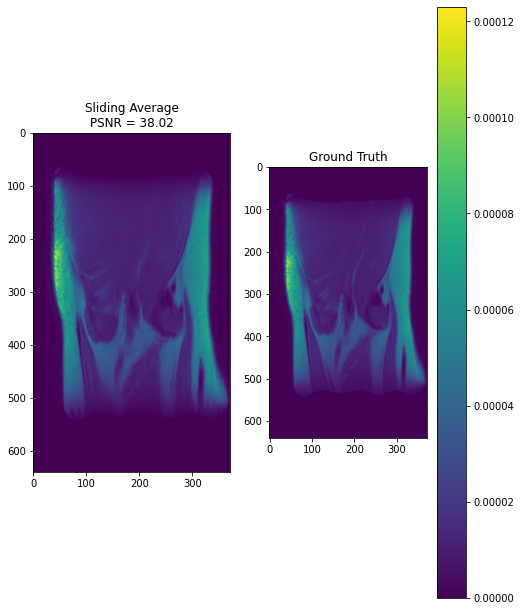

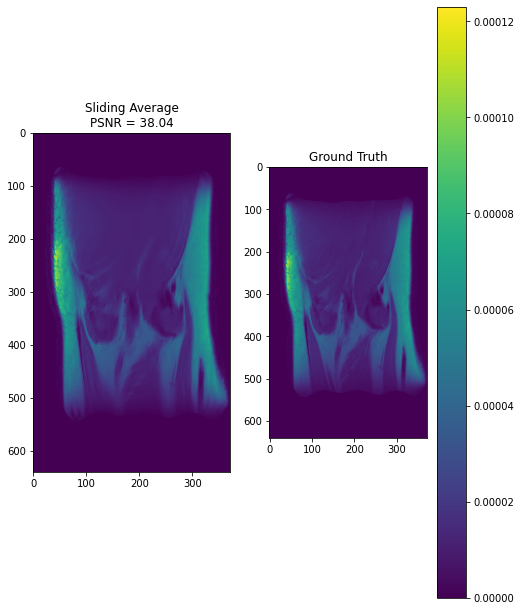

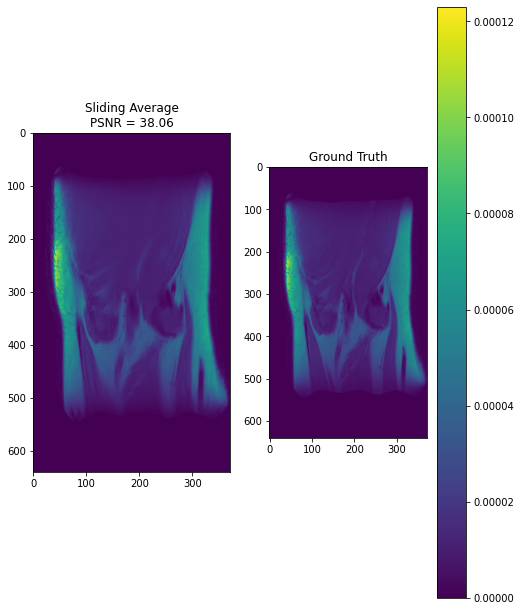

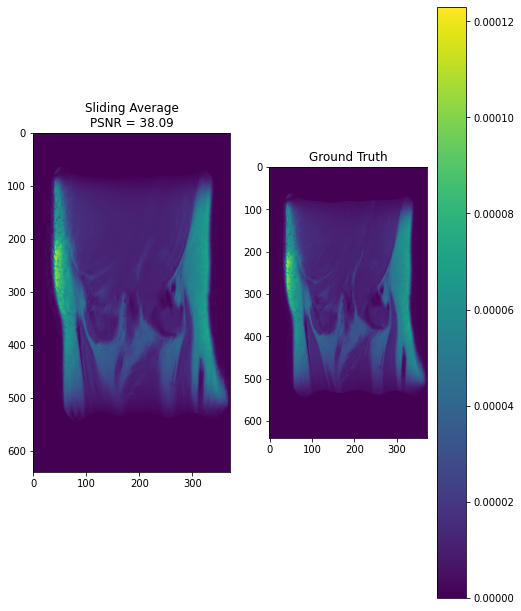

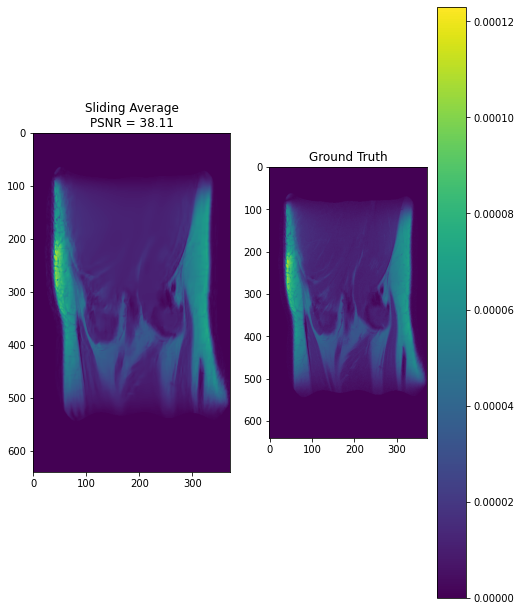

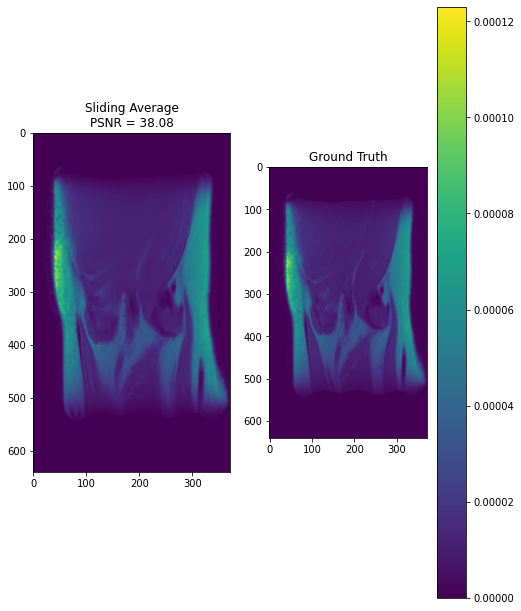

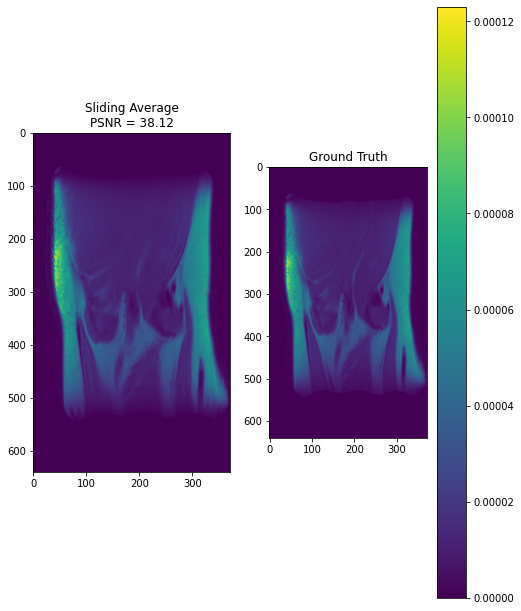

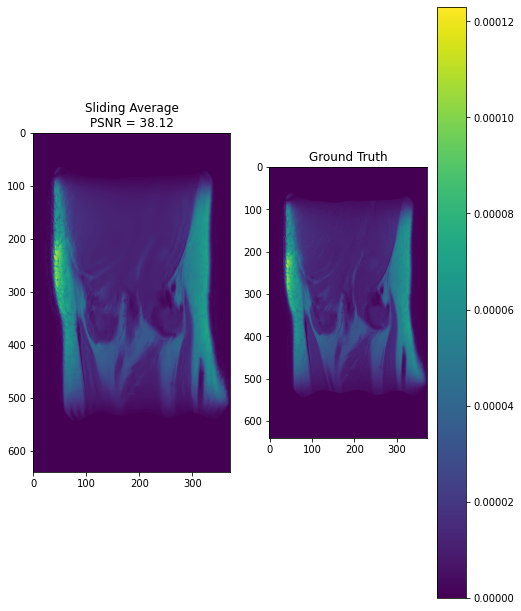

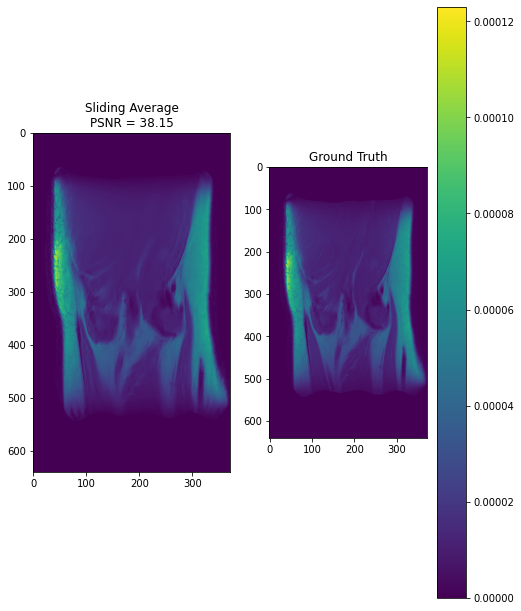

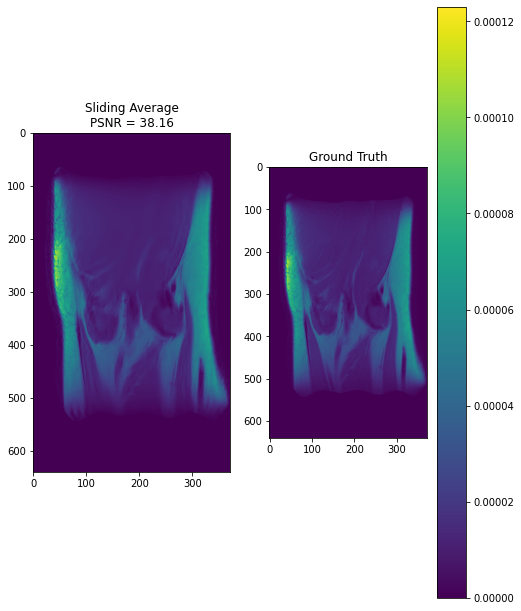

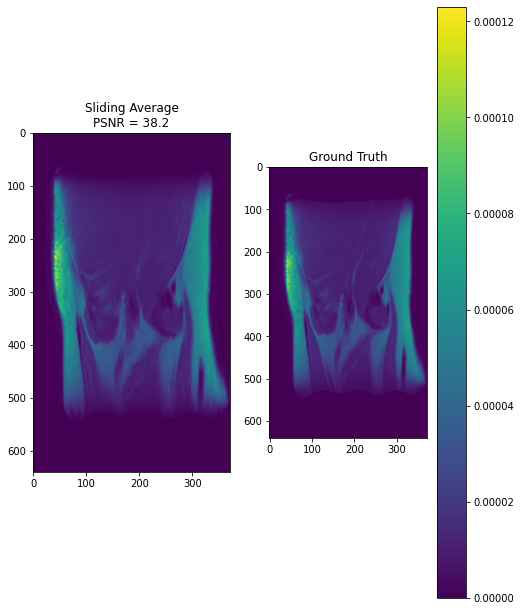

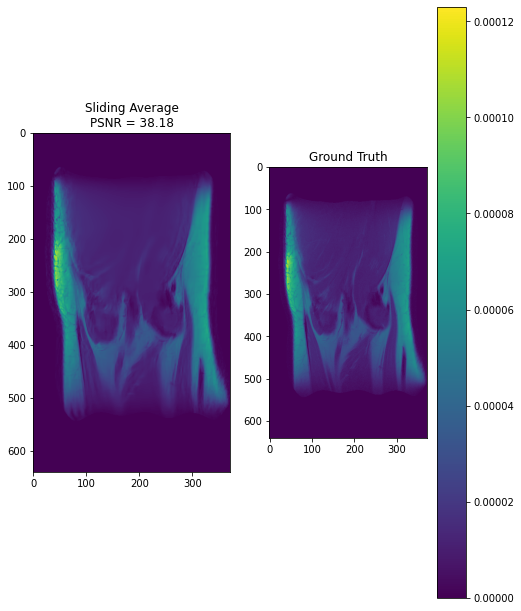

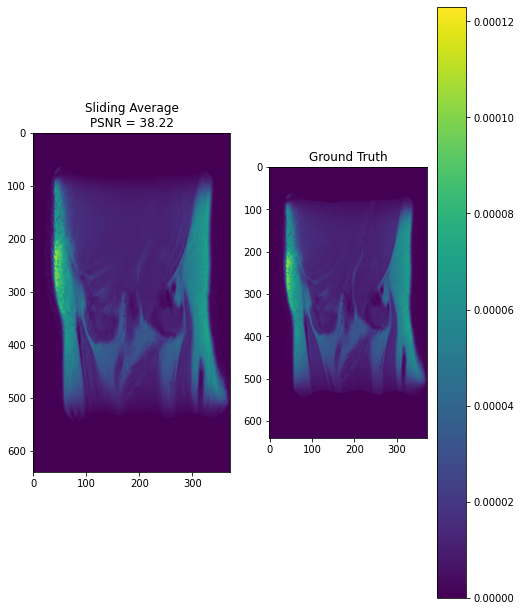

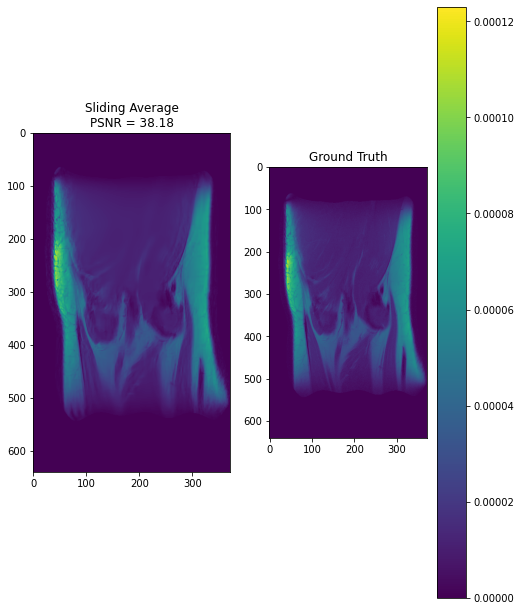

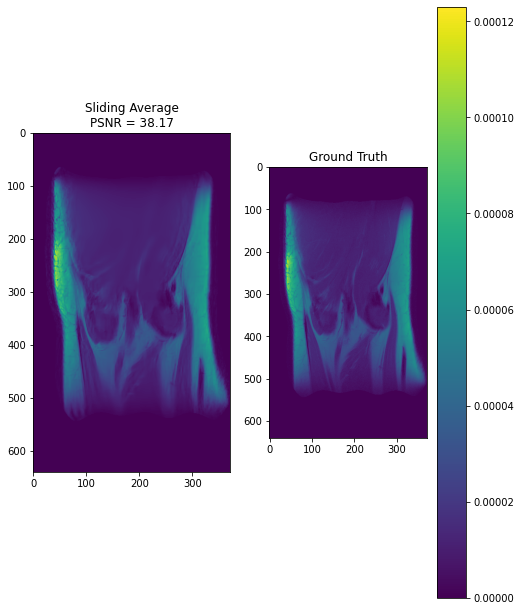

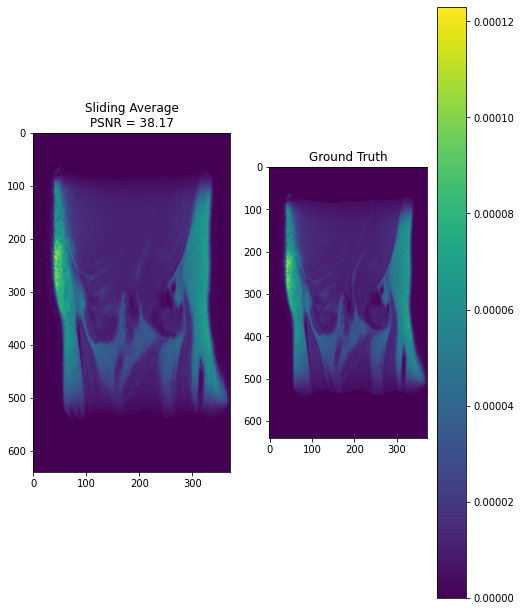

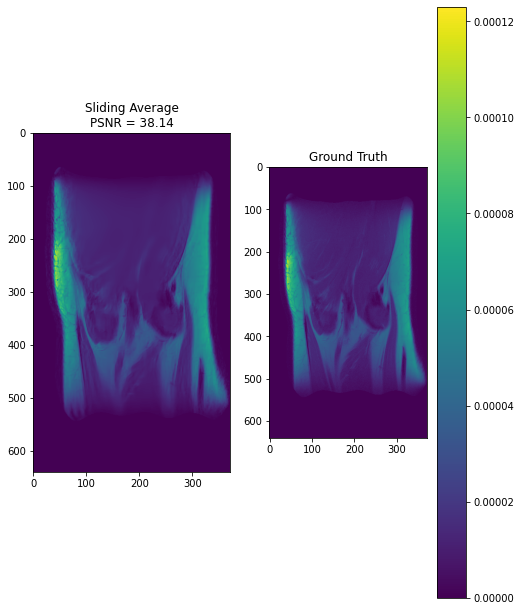

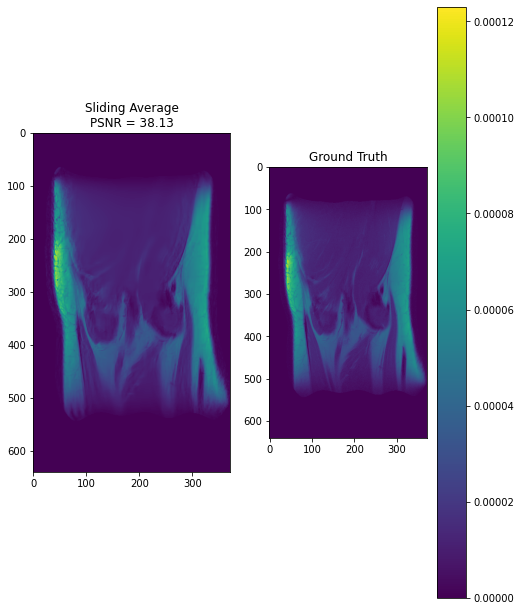

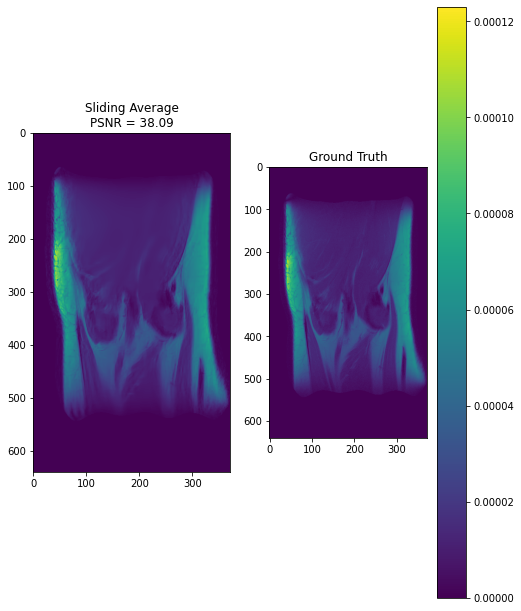

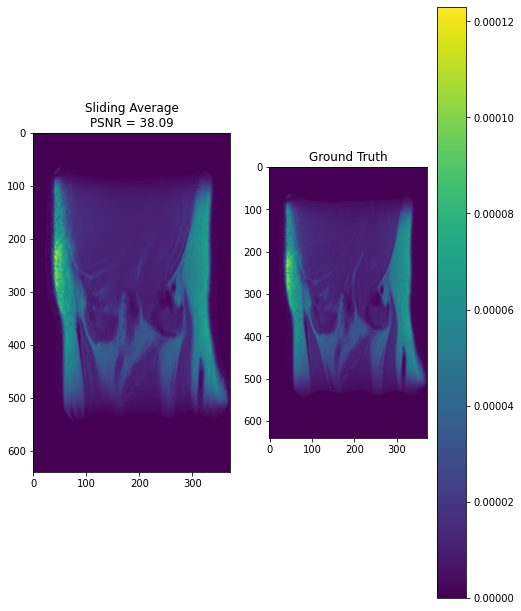

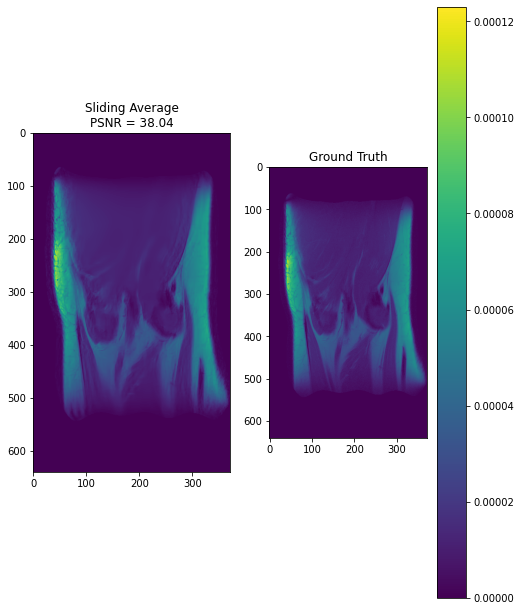

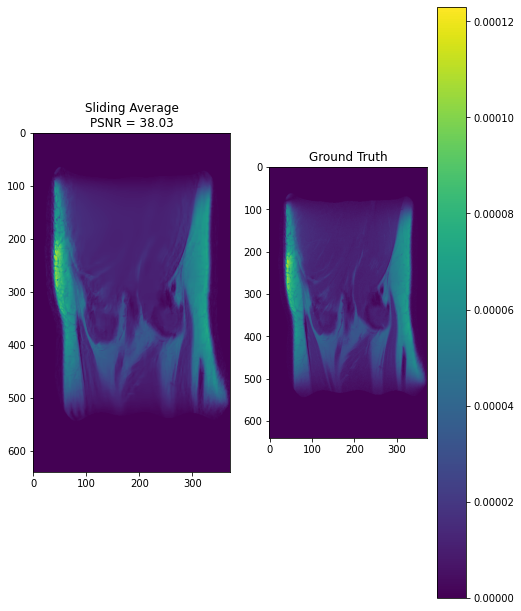

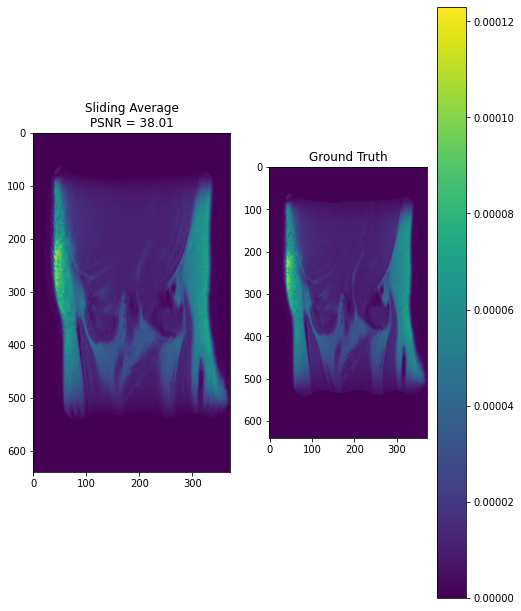

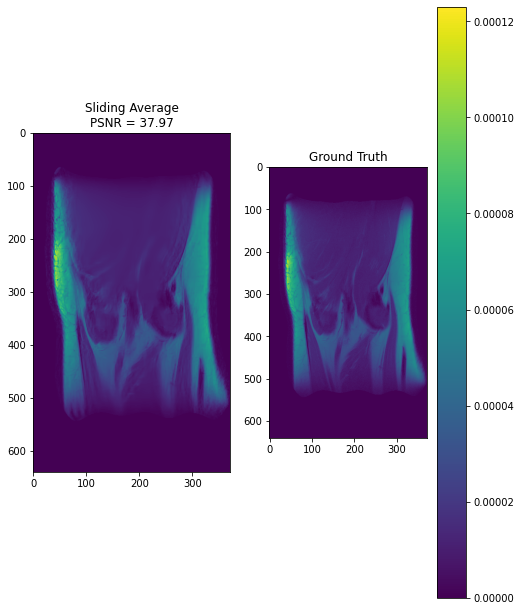

In [24]:


for epoch in tqdm(range(4000)):
    optimizer.zero_grad()
    net_output = net(ref.to(device)).squeeze()
        
    net_output = torch.view_as_complex(net_output.permute(1,2,0).contiguous())
    
    pred_ksp = mps_and_gt_to_ksp(mps1.to(device), net_output)
    
    new_pred_ksp = (1 - torch.tensor(mask_from_file,dtype=torch.complex64)).to(device) * pred_ksp.detach()/scale_factor \
    + mask_from_file.to(device) * ksp1.to(device)
    
    new_ref = ksp_and_mps_to_gt(new_pred_ksp, mps1.to(device)) 
    random_smoothing_temp = torch.zeros_like(new_ref).to(device)
    for jj in range(4):
        random_smoothing = new_ref + 1e-4 * torch.rand((640,372), dtype=torch.complex64).to(device)
        random_smoothing_temp += random_smoothing
    random_smoothing_final = random_smoothing_temp/4
    ref[:,0,:,:] = random_smoothing_final.real
    ref[:,1,:,:] = random_smoothing_final.imag
    
    loss = criterion(mask_from_file.to(device) * target_ksp.to(device), mask_from_file.to(device) * pred_ksp.squeeze().to(device))
    
    loss.backward()
    optimizer.step()
    
    out = img_map.to(device) * torch.abs(net_output)
    out /= torch.max(out)
    out = out.detach().squeeze()
    
    losses.append(loss.item())
    
    out_avg = out_avg * exp_weight + out * (1 - exp_weight)
    avg_psnr = compute_psnr(np.array(torch.abs(gt1))/np.max(np.array(torch.abs(gt1))), np.array(out_avg.cpu())/float(out_avg.max().item()))
    avg_psnrs.append(avg_psnr)
    
    if epoch%show_every == 0:
        plt.figure(figsize=(12,12))
                            
        plt.subplot(131)
        plt.imshow(out_avg.cpu())
        plt.title('Sliding Average\nPSNR = ' + str(round(avg_psnr, 2)))
        
        plt.subplot(132)
        plt.imshow(np.abs(gt1.numpy()))
        plt.title('Ground Truth')
        plt.colorbar()
                            
        plt.show()

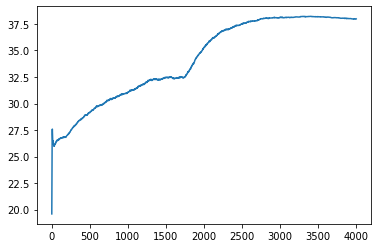

In [25]:
plt.plot(avg_psnrs)

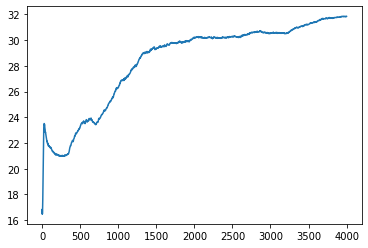

In [23]:
plt.plot(avg_psnrs)

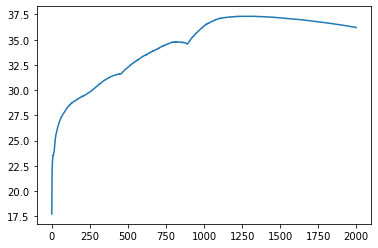

In [21]:
plt.plot(avg_psnrs)

In [32]:
import os
path = '/home/shijunliang/'
np.save(os.path.join(path,'DIP','deep-image-prior-master','result','Local_DIP_PSNR_1074_Unet_ori_evan_unroll.npy'),avg_psnrs)

In [26]:
print(np.max(avg_psnrs))

31.90061604400342


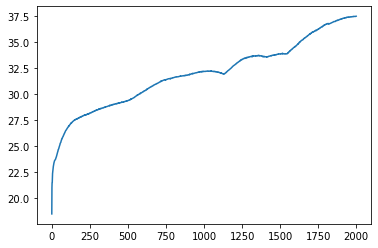

In [20]:
plt.plot(avg_psnrs)

In [21]:
import os
path = '/home/shijunliang/'
np.save(os.path.join(path,'DIP','deep-image-prior-master','result','Local_DIP_PSNR_1074_Unet_ori_evan_medium.npy'),avg_psnrs)

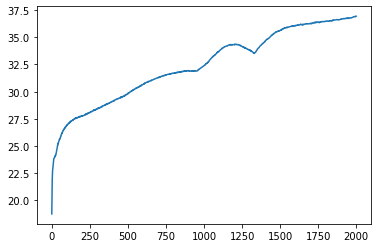

In [22]:
plt.plot(avg_psnrs)

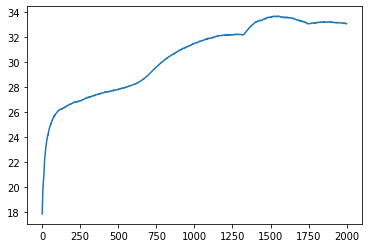

In [20]:
plt.plot(avg_psnrs)

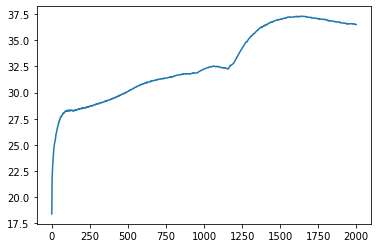

In [20]:
plt.plot(avg_psnrs)

In [22]:
import os
path = '/home/shijunliang/'
hg = np.load(os.path.join(path,'DIP','deep-image-prior-master','result','Local_DIP_PSNR_1074_Unet_hf_evan.npy'))

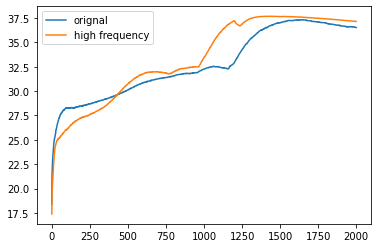

In [23]:
plt.plot(avg_psnrs,label ='orignal')
plt.plot(hg,label = 'high frequency')
plt.legend()

In [22]:
print(np.max(hg))
print(np.max(avg_psnrs))

37.67242327630887
37.58836891904255


In [23]:
import os
path = '/home/shijunliang/'
np.save(os.path.join(path,'DIP','deep-image-prior-master','result','Local_DIP_PSNR_1074_Unet_ori_evan.npy'),avg_psnrs)